# 작사가 인공지능 만들기
## 순환신경망(RNN)을 이용하여 문장 생성이 가능하다.
1. 데이터 다듬기
2. 인공지능 학습시키기
3. 잘 만들어졌는지 평가하기

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## 1. 데이터 다듬기(정제)
- glob 모듈을 이용하여 모든 문자열을 불러온다.
- 불러온 데이터를 `read().splitlines()`함수를 이용하여 파일을 한줄씩 읽어내자.
- `raw_corpus`변수에 한줄씩 리스트로 저장한다.

In [2]:
import glob
import os
import os, re
import tensorflow as tf

txt_file_path = '/content/gdrive/MyDrive/AIFFEL/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("<데이터 크기>:", len(raw_corpus))

for num, sentence in enumerate(raw_corpus[:9]):
  print(f'sentence[{num}]', f'"{sentence}"')

<데이터 크기>: 187088
sentence[0] "Yesterday, all my troubles seemed so far away"
sentence[1] "Now it looks as though they're here to stay"
sentence[2] "Oh, I believe in yesterday Suddenly, I'm not half the man I used to be"
sentence[3] "There's a shadow hanging over me."
sentence[4] "Oh, yesterday came suddenly Why she had to go I don't know she wouldn't say"
sentence[5] "I said something wrong, now I long for yesterday Yesterday, love was such an easy game to play"
sentence[6] "Now I need a place to hide away"
sentence[7] "Oh, I believe in yesterday Why she had to go I don't know she wouldn't say"
sentence[8] "I said something wrong, now I long for yesterday Yesterday, love was such an easy game to play"


## 2. 데이터 토큰화

- 문장을 출력해보니 특수기호나 공백과 같은 불필요한 정보가 많이 있다.
- 문장을 일정한 기준으로 쪼개는 **토큰화(Tokenize)**를 해주자.(불필요한 것은 없애고 문장으로 저장)
  - 문장 부호 양쪽에 공백 추가
  - 모든 문자들을 소문자로 변환
  - 특수문자는 모두 제거


In [3]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,¿,']+", " ", sentence)
    sentence = sentence.strip()
    sentence = '<start> ' + sentence + ' <end>'
    return sentence

print(preprocess_sentence("This @_is ;;;sample        sentence."))

<start> this is sample sentence . <end>


1. `sentence.lower().strip()` : 소문자로 바꾸고, 양쪽에 공백 지움
2. `re.sub(r"([?.!,¿])", r" \1 ", sentence)` : 특수문자 양쪽에 공백 추가
3. `re.sub(r'[" "]+', " ", sentence)` : 여러개의 공백은 하나의 공백으로 변경
4. `re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence)` : a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 변경
5. `sentence.strip()` : 다시 양쪽 공백을 지움
6. `<start> ' + sentence + ' <end>` : 문장 시작에 `<start>`, 끝에는 `<end>` 추가

In [4]:
corpus = [] # 정제된 문장 저장

for sentence in raw_corpus:
    if len(sentence) == 0: # 원하지 않는 문장은 건너뜀
      continue
    if len(sentence) == 1: # 한 단어는 건너뜀
      continue
    if sentence[-1] == ":": # 끝이 : 문장은 건너뜀
      continue
    if len(sentence.split(' ')) >= 13: 
      continue
    
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)
        
corpus[:9]

['<start> yesterday , all my troubles seemed so far away <end>',
 "<start> now it looks as though they're here to stay <end>",
 "<start> there's a shadow hanging over me . <end>",
 '<start> now i need a place to hide away <end>',
 '<start> now i need a place to hide away <end>',
 '<start> oh , i believe in yesterday <end>',
 '<start> speaking words of wisdom , let it be <end>',
 '<start> speaking words of wisdom , let it be <end>',
 '<start> let it be , let it be , let it be , let it be <end>']

**음...... 나름 깨끗해진거 같다.**   
이번 작사 인공지능은 노래가사를 만드는 것이라 지나치게 긴 문장은 필요없을 것 같으니 띄어쓰기 13개 이상은 제외시켜주자.

## 3. 텐서플로우를 통한 토큰화

>`tf.keras.preprocessing.text.Tokenizer`패키지는 정제된 데이터를 토큰화하고,   
단어 사전을 만들어주며, 데이터를 숫자로 변환까지해주는 아주 좋은 패키지다.   
이 과정을 **벡터화(vectorize)**, 숫자로 변환된 데이터를 **텐서(tensor)**라고 한다.




In [5]:
# 토큰화 할 때 텐서플로우의 Tokenizer와 pad_sequences를 같이 사용한다.
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        # 12,000단어를 기억할 수 있는 tokenizer만들기
        # 위쪽 preprocess_sentence에서 문장 정제를 하여 filters가 필요없음
        # 12,000단어에 포함되지 못한 단어는 '<unk>'로 바꿈
        num_words=12000, 
        filters=' ',
        oov_token="<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장 완성
    tokenizer.fit_on_texts(corpus)
    # 준비된 tokenizer를 이용해 corpus를 Tensor로 변환
    tensor = tokenizer.texts_to_sequences(corpus)
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춤
    # 만약 시퀀스가 짧으면 문장 뒤에 패딩을 붙여 길이를 맞춤
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=15)  
    
    print(tensor,'\n',tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[  2 895   4 ...   0   0   0]
 [  2  46  13 ...   0   0   0]
 [  2 167   9 ...   0   0   0]
 ...
 [  2 100  92 ...   0   0   0]
 [  2 109 681 ...   0   0   0]
 [  2   8  46 ...   0   0   0]] 


- `tf.keras.preprocessing.text.Tokenizer()`를 이용해 corpus를 텐서로 변환

In [6]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 9:
      break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : the
6 : i
7 : you
8 : and
9 : a


- 저장된 단어장을 출력해보자.
- idx로 tokenizer에 저장된 단어를 하나씩 출력해보았다.

## 4. 평가 데이터 분리(train, validation)

In [7]:
src_input = tensor[:, :-1]
tgt_input = tensor[:, 1:] # tensor에서 <start>를 잘라내서 타겟 문장 생성

print(src_input[0])
print(tgt_input[0])

[   2  895    4   23   12 2645 2004   29  358  134    3    0    0    0]
[ 895    4   23   12 2645 2004   29  358  134    3    0    0    0    0]


- tensor에서 마지막 토큰을 잘래내 소스 문장을 생성함.
- 마지막 토큰은 `<end>`가  아니라 `<pad>`일 가능성이 높음.

In [8]:
from sklearn.model_selection import train_test_split
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input,
                                                         tgt_input,
                                                         test_size=0.2,
                                                         random_state=7,)

In [9]:
print("Source Train:", enc_train.shape)
print("Target Train:", dec_train.shape)

Source Train: (126522, 14)
Target Train: (126522, 14)


In [10]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE
VOCAB_SIZE = tokenizer.num_words + 1   
dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>

- `tf.data.Dataset.from_tensor_slices()`를 이용해 corpus 텐서를 `tf.data.Dataset`객체로 변환

## 5. 모델 구조

In [37]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 256 # 워드 벡터의 차원수, 단어가 추상적으로 표현되는 크기
hidden_size = 3000
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

- Embedding 레이어를 통해 인덱스 값을 해당 인덱스 번째의 워드 벡터로 바꿔준다.
- embedding_size를 256으로 feature 갯수를 늘린다.
- hidden_size를 1024로 노드 수를 를린다. (3000 변경)

In [38]:
for src_sample, tgt_sample in dataset.take(1):
  break

# 한 배치만 불러온 데이터를 모델에 넣어봅니다
model(src_sample)

<tf.Tensor: shape=(256, 14, 12001), dtype=float32, numpy=
array([[[ 1.61366013e-04, -1.23211081e-04, -3.15862300e-04, ...,
         -3.03147790e-05, -5.16527798e-05,  8.15175226e-05],
        [-2.17743596e-04, -1.73142238e-04, -5.53463236e-04, ...,
          1.89658938e-04, -8.60463479e-05,  1.19003598e-04],
        [-6.35291217e-04, -1.75578505e-04, -7.48004706e-04, ...,
          2.09633654e-04, -5.00675291e-04,  1.92783147e-04],
        ...,
        [-2.03809119e-03,  7.99246307e-04,  3.61146918e-03, ...,
          8.08807963e-04, -1.08976429e-03, -1.41562393e-03],
        [-2.07354245e-03,  6.36589015e-04,  4.19105869e-03, ...,
          1.01770530e-03, -1.29641138e-03, -1.84691581e-03],
        [-2.09657336e-03,  4.82483389e-04,  4.66945488e-03, ...,
          1.18752522e-03, -1.48050790e-03, -2.25411216e-03]],

       [[ 1.61366013e-04, -1.23211081e-04, -3.15862300e-04, ...,
         -3.03147790e-05, -5.16527798e-05,  8.15175226e-05],
        [ 3.90829780e-04, -1.01405021e-04, -5

- 출력된 모델 텐서의 shape를 보면 `shape=(256, 20, 7001)`을 알 수 있다.
- 7001은 Dense 레이어의 출력 차원수
- 256은 embedding_size로 dataset.take(1)을 통해서 1개의 배치, 256개의 문장을 나타낸다.
- 20은 LSTM 자신에게 입력된 시퀀스의 길이만큼 동일한 길이의 시퀀스를 출력   
(`return_sequences=Fale`라면 LSTM 레이어는 1개의 벡터만 출력)

In [39]:
model.summary()

Model: "text_generator_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     multiple                  3072256   
                                                                 
 lstm_2 (LSTM)               multiple                  39084000  
                                                                 
 lstm_3 (LSTM)               multiple                  72012000  
                                                                 
 dense_1 (Dense)             multiple                  36015001  
                                                                 
Total params: 150,183,257
Trainable params: 150,183,257
Non-trainable params: 0
_________________________________________________________________


In [40]:
# Directory where the checkpoints will be saved
cp_dir = './training_checkpoints'
# Name of the checkpoint files
cp_epoch = os.path.join(cp_dir, "lyrics_epoch")

cp_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=cp_epoch,
    save_weights_only=True)

## 6. 모델 학습

In [41]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
optimizer = tf.keras.optimizers.Adam()
model.compile(loss=loss, optimizer=optimizer)

# cf. validation_data와 batch_size는 같이 지정해야 오류가 발생하지 않음
history = model.fit(dataset, epochs=10, validation_data=(enc_val, dec_val), batch_size=128, callbacks=cp_cb)
history

Epoch 1/10
617/617 [==============================] - 621s 1s/step - loss: 3.2270 - val_loss: 2.8078
Epoch 2/10
617/617 [==============================] - 624s 1s/step - loss: 2.6897 - val_loss: 2.3850
Epoch 3/10
617/617 [==============================] - 626s 1s/step - loss: 2.3128 - val_loss: 1.9716
Epoch 4/10
617/617 [==============================] - 625s 1s/step - loss: 1.9430 - val_loss: 1.6176
Epoch 5/10
617/617 [==============================] - 627s 1s/step - loss: 1.6187 - val_loss: 1.3431
Epoch 6/10
617/617 [==============================] - 626s 1s/step - loss: 1.3673 - val_loss: 1.1564
Epoch 7/10
617/617 [==============================] - 627s 1s/step - loss: 1.1862 - val_loss: 1.0402
Epoch 8/10
617/617 [==============================] - 628s 1s/step - loss: 1.0776 - val_loss: 0.9791
Epoch 9/10
617/617 [==============================] - 627s 1s/step - loss: 1.0214 - val_loss: 0.9472
Epoch 10/10
617/617 [==============================] - 627s 1s/step - loss: 0.9918 - val_lo

- hidden_size를 1024 했을 때는 val_loss가 2.3정도 나왔었다.
- 위의 val_loss는 hidden_size를 3000으로 하여 0.93이 나왔다.
- val_loss가 줄어든 만큼 영향력이 있는지 살펴보자.

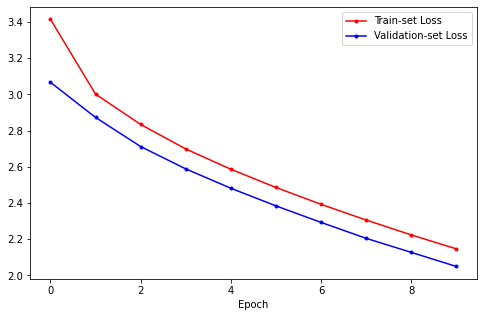

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

plt.plot(history.history['loss'], marker='.', c='red', label='Train-set Loss')
plt.plot(history.history['val_loss'], marker='.', c='blue', label='Validation-set Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

- 아쉽게도 hidden_size가 1024일 때의 사진이 날라갔다.
- 그러나 위의 hidden_size는 3000일ㄷ 때의 그래프인데 형상이 완전 동일하게 나왔다.

In [20]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=15):
    test_input = tokenizer.texts_to_sequences([init_sentence]) # 테스트를 위해 입력받은 init_sentence를 텐서로 변환
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]
    while True:
        predict = model(test_tensor) # 입력받은 문장의 텐서 입력
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] # 예측한 마지막 단어를 통해 다음 단어 예측 생성
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1) # 예측한 단어를 입력한 마지막 단어 뒤에 붙여줌

        # end_token을 예측하지 않거나 max_len 범위에 없다면 while 루프로 다음 단어 예측 생성
        if predict_word.numpy()[0] == end_token:
          break
        if test_tensor.shape[1] >= max_len:
          break

    generated = ""
    # tokenizer 이용해 word index를 단어로 하나씩 변환
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated # 최종 모델이 생성한 자연어 문장

## 🤔 생각을 해보자.


1. generate_text에는 4개의 파라미터
  - `model`: `TextGenerator` 모델 구조
  - `tokenizer`: 토큰화한 문자
  - `init_sentence="<start>"`: 입력받은 init_sentence를 텐서로 변환
  - `max_len=15`: 최대 15
2. while 반복문 진입
 - model을 통해 입력받은 문장의 텐서 입력
 - 예측한 마지막 단어를 통해 다음 단어 예측 생성
 - 예측한 단어를 입력한 마지막 단어에 붙여줌
 - `end_token`을 예측하지 않거나, `max_len` 범위에 없으면 다시 루프하여 단어 예측
3. 생성된 tensor 안에 있는 word index를 tokenizer를 이용해 word index를 단어로 하나씩 변환
4. 모델로 최종 생성된 자연어 `return`

In [64]:
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=15)

'<start> i love you <end> '

In [65]:
words = ['marry me', 'heart', 'next time', 'I', 'you', 'he', 'singing', 'call', 'ring']
for start in words:
    print(generate_text(model, tokenizer, init_sentence= ' '.join(["<start>", start]), max_len=20))

<start> marry me on the way i know <end> 
<start> heart burnin' , still yearnin' <end> 
<start> next time you need me there i won't make it <end> 
<start> i don't know why i spend my time <end> 
<start> you know that i like that <end> 
<start> he said , i just think you're depressed <end> 
<start> singing to the city lights , <end> 
<start> call me weezy da king or call me weezy da crack <end> 
<start> ring the bells that still can ring forget your perfect offering <end> 


## 😇 오호!~ 꽤나??


나름 만족할만한 결과가 나온거 같다.   
batch_size를 256으로 설정 후 결과를 보고 싶은데 GPU의 사용제한.... 나중에 돌려보는 걸로....  



다만 알수있었던 것은 노드가 1024일 경우 문장이 매우 단조로우면서 부자연스러운 것이 많았는데,   
3000일 경우 비교적 괜찮게 나온 것 같다. 패턴 학습이 더 좋아진건가??


추가 테스트를 더 해보고 업뎃을 해보도록 하겠다. -이상!-
